

ANALYZING DATASET: ../datasets/data_export_1741699774916.csv

Loading data from ../datasets/data_export_1741699774916.csv...
Dataset shape: (159, 100)
Missing values: 0
Training models...
  Training Linear Regression...
  Training Ridge Regression...
  Training Lasso Regression...
  Training ElasticNet...
  Training Random Forest...
  Training Gradient Boosting...
  Training XGBoost...

Model Evaluation:
  Linear Regression: RMSE=1673.7767, MAE=1475.7984, R²=0.6903
  Ridge Regression: RMSE=1675.3697, MAE=1477.2605, R²=0.6897
  Lasso Regression: RMSE=2110.8040, MAE=1115.6231, R²=0.5075
  ElasticNet: RMSE=1675.8358, MAE=1477.5179, R²=0.6896
  Random Forest: RMSE=591.1766, MAE=484.0117, R²=0.9614
  Gradient Boosting: RMSE=548.3207, MAE=412.4817, R²=0.9668
  XGBoost: RMSE=655.4936, MAE=490.1857, R²=0.9525


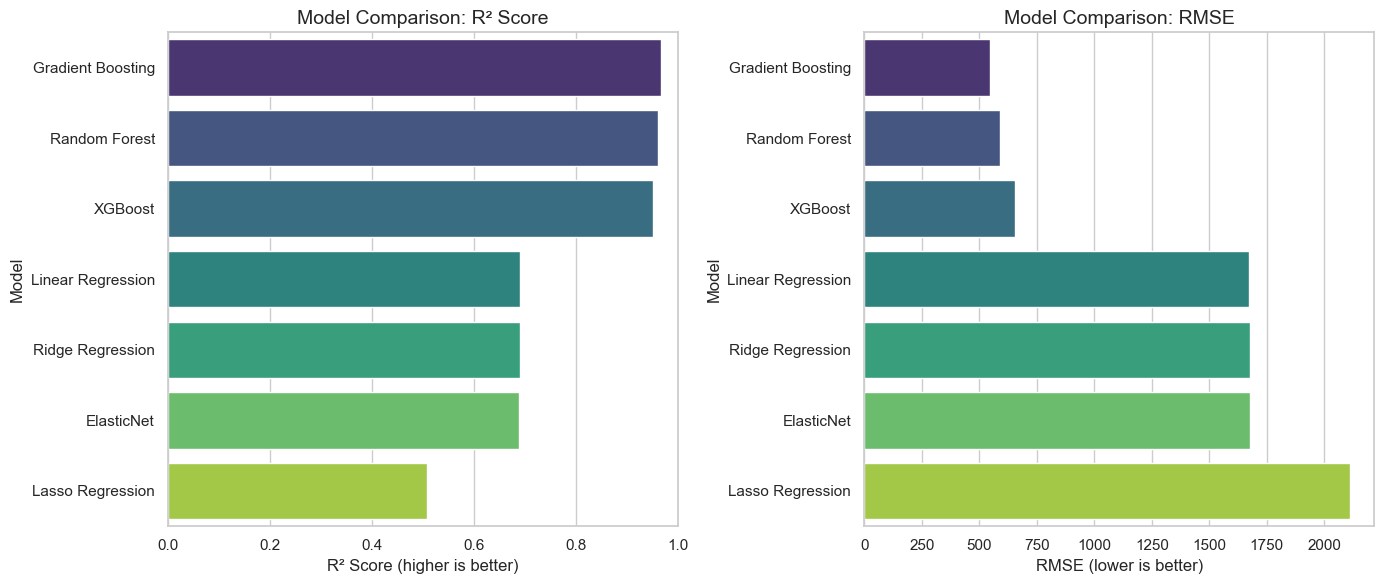


Best model: Gradient Boosting with R² = 0.9668


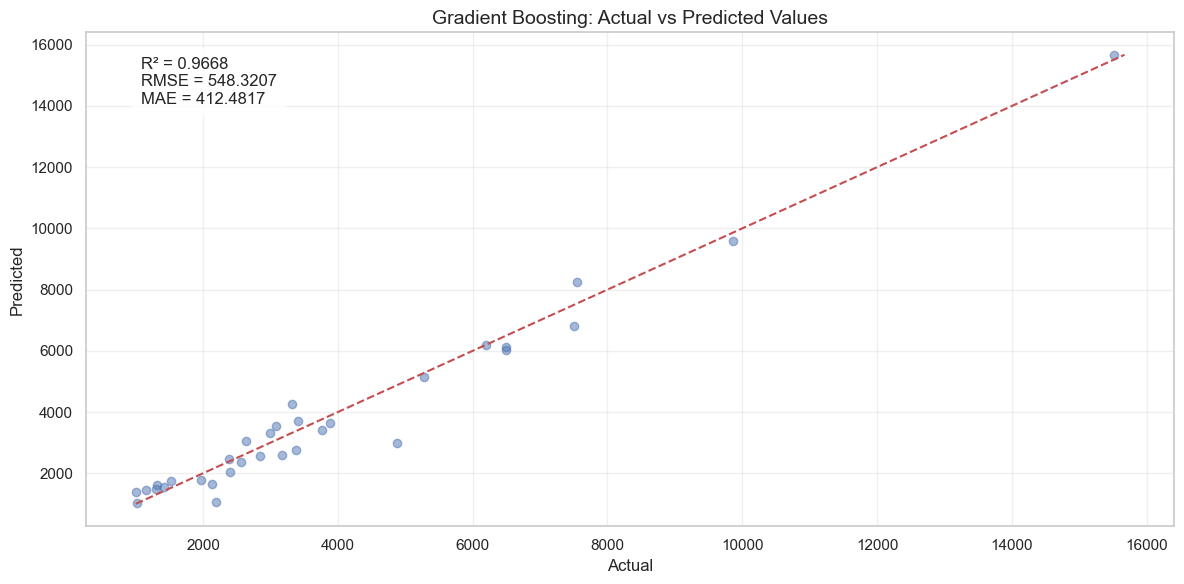

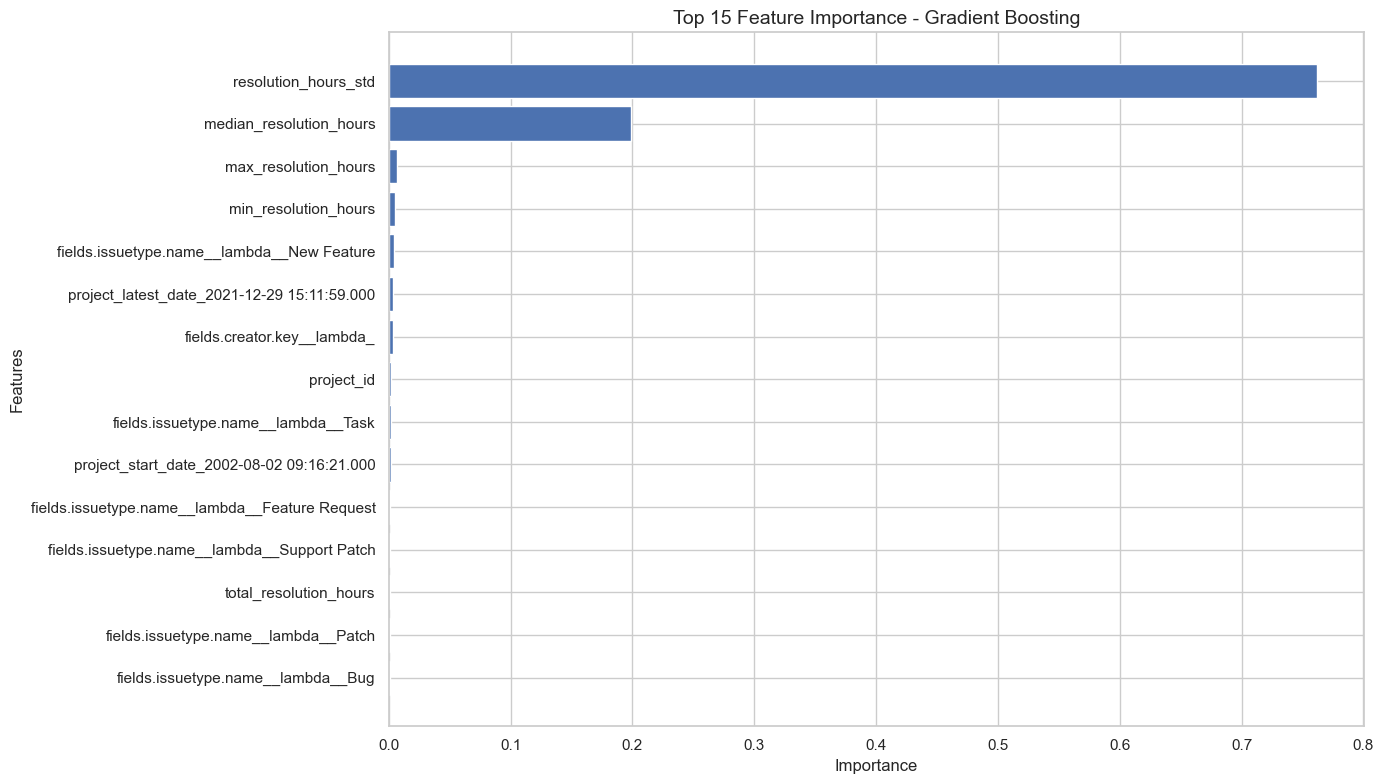


Top 10 Most Important Features:
                                        Feature  Importance
14                         resolution_hours_std    0.762119
13                      median_resolution_hours    0.198503
12                         max_resolution_hours    0.006374
11                         min_resolution_hours    0.005231
10   fields.issuetype.name__lambda__New Feature    0.004557
9   project_latest_date_2021-12-29 15:11:59.000    0.003598
8                   fields.creator.key__lambda_    0.003146
7                                    project_id    0.002092
6           fields.issuetype.name__lambda__Task    0.002021
5    project_start_date_2002-08-02 09:16:21.000    0.001557


ANALYZING DATASET: ../datasets/data_export_1741772203780.csv

Loading data from ../datasets/data_export_1741772203780.csv...
Dataset shape: (190, 100)
Missing values: 0
Training models...
  Training Linear Regression...
  Training Ridge Regression...
  Training Lasso Regression...
  Training ElasticNet..

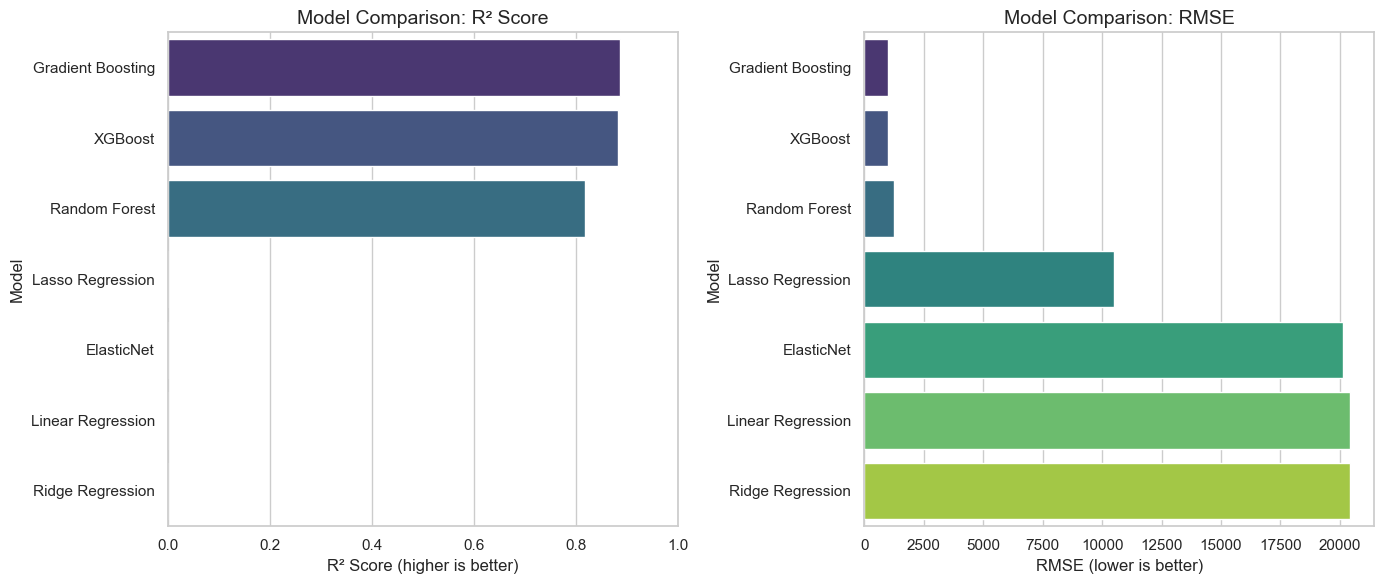


Best model: Gradient Boosting with R² = 0.8869


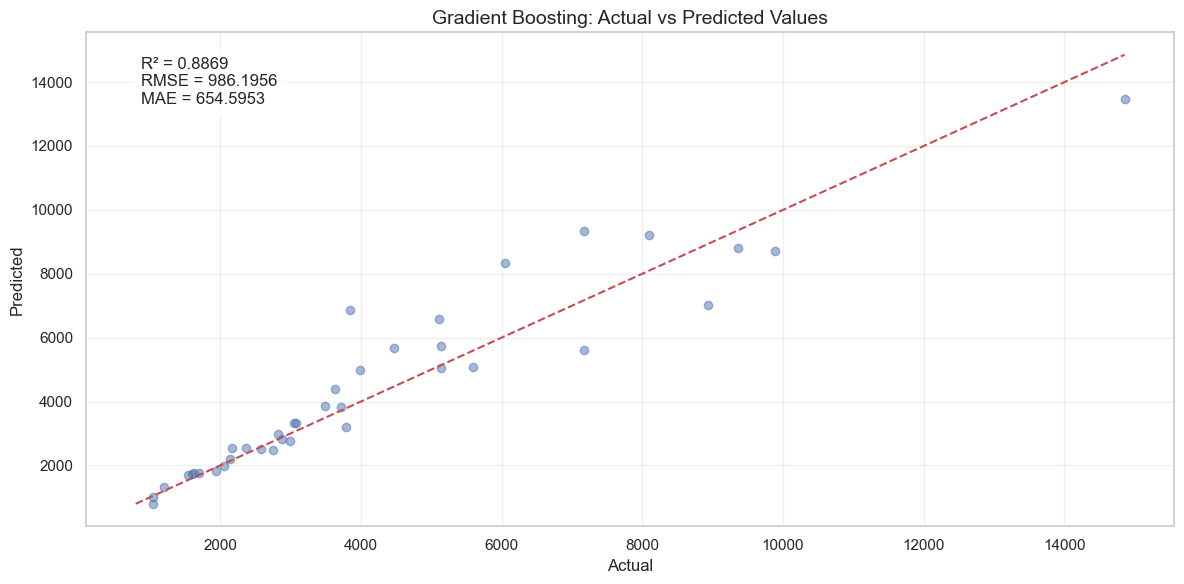

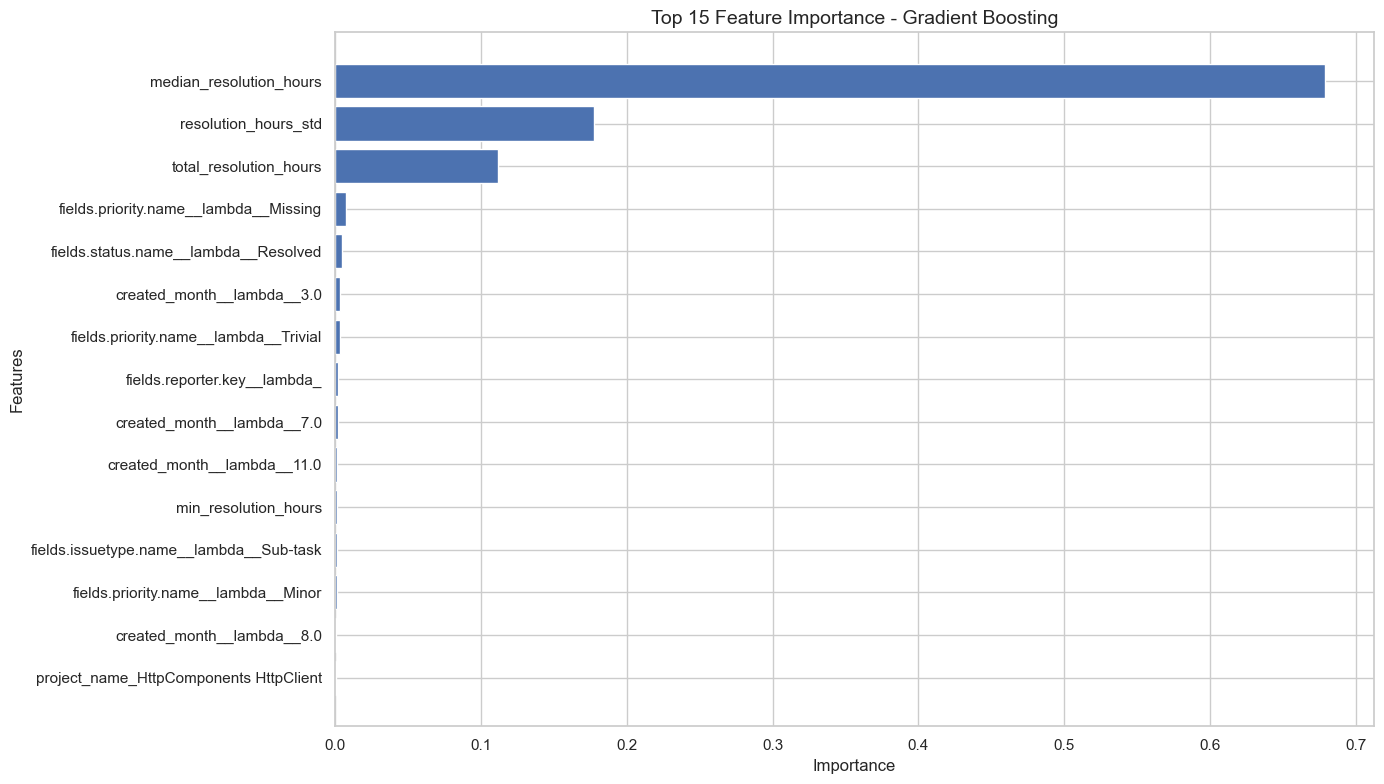


Top 10 Most Important Features:
                                  Feature  Importance
14                median_resolution_hours    0.678657
13                   resolution_hours_std    0.177432
12                 total_resolution_hours    0.111842
11  fields.priority.name__lambda__Missing    0.007389
10   fields.status.name__lambda__Resolved    0.004513
9              created_month__lambda__3.0    0.003014
8   fields.priority.name__lambda__Trivial    0.002929
7            fields.reporter.key__lambda_    0.002166
6              created_month__lambda__7.0    0.001935
5             created_month__lambda__11.0    0.001313


In [ ]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style for better visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Function to load and preprocess data
def load_and_preprocess(file_path):
    # Load the data
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Handle infinity values
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Get basic info
    print(f"Dataset shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    # Fill missing values with column median
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns, fill with mode
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")
    
    return df

# Function to prepare data for modeling
def prepare_data(df, target_col='avg_resolution_hours'):
    if target_col not in df.columns:
        available_cols = [col for col in df.columns if 'hour' in col.lower()]
        if available_cols:
            target_col = available_cols[0]
            print(f"Target column not found. Using {target_col} instead.")
        else:
            raise ValueError(f"Target column {target_col} not found in dataset")
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Clean column names - replace problematic characters
    X.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_') for col in X.columns]
    
    # Handle categorical features with one-hot encoding
    X = pd.get_dummies(X, drop_first=True)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    return X_train_scaled, X_test_scaled, y_train, y_test, X.columns

# Function to train multiple regression models
def train_models(X_train, y_train):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    }
    
    print("Training models...")
    for name, model in models.items():
        print(f"  Training {name}...")
        model.fit(X_train, y_train)
    
    return models

# Function to evaluate models
def evaluate_models(models, X_test, y_test):
    results = {}
    print("\nModel Evaluation:")
    
    for name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'predictions': y_pred
        }
        
        print(f"  {name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
    
    return results

# Function to visualize model performance
def visualize_performance(results):
    # Create a performance comparison dataframe
    performance_df = pd.DataFrame({
        'Model': list(results.keys()),
        'RMSE': [results[model]['RMSE'] for model in results],
        'MAE': [results[model]['MAE'] for model in results],
        'R²': [results[model]['R²'] for model in results]
    })
    
    # Sort by R²
    performance_df = performance_df.sort_values('R²', ascending=False)
    
    # Plot R² comparison
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='R²', y='Model', data=performance_df, palette='viridis')
    plt.title('Model Comparison: R² Score', fontsize=14)
    plt.xlabel('R² Score (higher is better)', fontsize=12)
    plt.xlim(0, 1)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='RMSE', y='Model', data=performance_df, palette='viridis')
    plt.title('Model Comparison: RMSE', fontsize=14)
    plt.xlabel('RMSE (lower is better)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return performance_df

# Function to visualize predictions vs actual values for the best model
def visualize_predictions(best_model_name, results, y_test):
    plt.figure(figsize=(12, 6))
    
    # Get predictions for the best model
    y_pred = results[best_model_name]['predictions']
    
    # Scatter plot of actual vs predicted
    plt.scatter(y_test, y_pred, alpha=0.5)
    
    # Perfect prediction line
    max_val = max(max(y_test), max(y_pred))
    min_val = min(min(y_test), min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'{best_model_name}: Actual vs Predicted Values', fontsize=14)
    plt.xlabel('Actual', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    
    # Add metrics text
    r2 = results[best_model_name]['R²']
    rmse = results[best_model_name]['RMSE']
    mae = results[best_model_name]['MAE']
    
    plt.annotate(f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nMAE = {mae:.4f}',
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
                 fontsize=12, ha='left', va='top')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Function to analyze feature importance
def analyze_feature_importance(models, X_test, y_test, feature_names, top_n=15):
    # Clean feature names to avoid plot errors
    feature_names = [str(name).replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_') for name in feature_names]
    best_model_name = max(
        [(name, model_info['R²']) for name, model_info in results.items()],
        key=lambda x: x[1]
    )[0]
    
    best_model = models[best_model_name]
    
    plt.figure(figsize=(14, 8))
    
    # Different approaches based on model type
    if hasattr(best_model, 'feature_importances_'):
        # For tree-based models
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[-top_n:]
        
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
        
    else:
        # Use permutation importance for other models
        perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean
        indices = np.argsort(importances)[-top_n:]
        
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
    
    plt.title(f'Top {top_n} Feature Importance - {best_model_name}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': importances[indices]
    }).sort_values('Importance', ascending=False)

# Main execution
if __name__ == "__main__":
    # Define multiple dataset files
    file_paths = [
        '../datasets/data_export_1741699774916.csv',
        '../datasets/data_export_1741772203780.csv',

        # Add more dataset paths here as needed
        # 'datasets/second_dataset.csv',
        # 'datasets/third_dataset.csv',
    ]
    
    # Process each dataset
    for file_path in file_paths:
        print(f"\n\n{'='*50}")
        print(f"ANALYZING DATASET: {file_path}")
        print(f"{'='*50}\n")
        
        try:
            # Load and preprocess data
            df = load_and_preprocess(file_path)
            
            # Prepare data for modeling
            X_train, X_test, y_train, y_test, feature_names = prepare_data(df)
            
            # Train models
            models = train_models(X_train, y_train)
            
            # Evaluate models
            results = evaluate_models(models, X_test, y_test)
            
            # Visualize performance
            performance_df = visualize_performance(results)
            
            # Get best model
            best_model_name = performance_df.iloc[0]['Model']
            print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['R²']:.4f}")
            
            # Visualize predictions
            visualize_predictions(best_model_name, results, y_test)
            
            # Analyze feature importance
            importance_df = analyze_feature_importance(models, X_test, y_test, feature_names)
            
            print("\nTop 10 Most Important Features:")
            print(importance_df.head(10))
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue